In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import cma
import os
import model
import params
import utils

In [25]:
#timesteps
dt = 0.0001
minutes = 60

Kd_wt = 25.4 #nM, experimental values
Kd_short = 147.7 #nM, experimental values

#K_d = k_off / k_on

WT_init = 1 #nM, from experimental setup
short_init = 1 #nM
dicer_init = 5 #nM
mirna = 0

k1 = params.ka1
k_1 = Kd_wt * k1
k2 = params.ka_1
k_2 = Kd_short * k2
k3 = params.ka2

theta = [k1, k2, k3]

In [26]:
#data fig 1
time = np.array([0, 5, 10, 20, 40, 60])
WT_y = np.array([0, 0.11144276160503169, 0.16566679779700877, 0.23905143587726366, 0.2954956726986665, 0.2946793863099961])
short_y = np.array([0, 0.0033684107002276975, 0.007599822974028003, 0.010019177812737812, 0.009603658536577298, 0.01242378048779691])

In [27]:
#find curve fit for experimental data for plotting purposes
#NB! logarithmic trendline!
WT_popt, WT_pcov = curve_fit(lambda t, a, b: a * np.log(t) + b,
                            time[1:], WT_y[1:]) #exclude first point as == origin

short_popt, short_pcov = curve_fit(lambda t, a, b: a * np.log(t) + b,
                            time[1:], short_y[1:]) #exclude first point as == origin

In [28]:
WT_popt

array([ 0.07927374, -0.01165457])

In [29]:
#create array with curve_fit data
x = np.linspace(0,60,600)

WT_pred = np.zeros(len(x))
short_pred = np.zeros(len(x))

for i in range(len(x)):
    WT_pred[i] = WT_popt[0] * np.log(x[i]) + WT_popt[1]
    short_pred[i] =  short_popt[0] * np.log(x[i]) + short_popt[1]

C:\Users\op20001\AppData\Local\Temp/ipykernel_19128/2447705808.py:8: RuntimeWarning: divide by zero encountered in log
  WT_pred[i] = WT_popt[0] * np.log(x[i]) + WT_popt[1]
C:\Users\op20001\AppData\Local\Temp/ipykernel_19128/2447705808.py:9: RuntimeWarning: divide by zero encountered in log
  short_pred[i] =  short_popt[0] * np.log(x[i]) + short_popt[1]


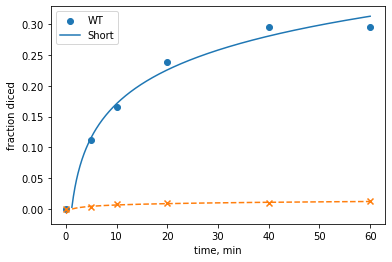

In [30]:
fig = plt.figure()

ax = plt.subplot()

ax.scatter(time, WT_y,
          color = 'C0')
ax.plot(x[12:], WT_pred[12:],
       color = 'C0')

ax.scatter(time, short_y,
           color = 'C1',
          marker = 'x')
ax.plot(x, short_pred,
       color = 'C1',
       linestyle = '--')

ax.set_xlabel('time, min')
ax.set_ylabel('fraction diced')
#ax.set_ylim(0.01,0.35)

ax.legend(['WT', 'Short'])

#plt.savefig(r'Figures/linear_fit.png', dpi = 600, bbox_inches = 'tight')

plt.show()

In [31]:
def curveError(model_values, time, ts):
    """
    Error function for ODE model optimisation based on predicted values from 
    scipy.optimize.curve_fit
    """
    
    WT_pred = np.zeros(len(time))
    for i in range(len(time)):
        WT_pred[i] = WT_popt[0] * np.log(time[i]) + WT_popt[1]
        
    return utils.Error(WT_pred, model_values, time, ts)   
    

In [32]:
def ErrorODE(theta):
    """
    Error function for ODE model based on error function described in utils module
    """
    WT_diced, short_diced, ts = model.frac_diced_ODE(theta)
    
    model_values =  np.array([WT_diced, short_diced])
    
    return utils.error_ODE(model_values = model_values, ts = ts)

In [33]:
theta

[1.0285752, 26.125810079999997, 0.180311]

In [128]:
def ErrorODE(theta, time, data_values = None):
    """
    Error function for ODE model based on error function described in utils module
    """
    
    ka, kb, kc = theta
    
    inits = [params.init_premirna1, params.init_premirna1_dicer, \
             params.init_dicer, params.init_mirna1]
    
    def model(t, inits):
        
        
        premiR = inits[1]*ka - inits[0]*inits[2]*kb
        premiR_dicer = inits[0]*inits[2]*kb - inits[1]*(ka + kc)
        dicer = inits[1]*(ka + kc) - inits[0]*inits[2]*kb
        mirna = inits[1]*kc
        
        return premiR, premiR_dicer, dicer, mirna
    
    sol = solve_ivp(model, (0, int(params.minutes)), inits)
    
    premiR = sol.y[0]
    
    diced = np.zeros(len(premiR))
    
    for i in range(len(diced)):
        diced[i] = (premiR[0] - premiR[i]) / premiR[0]
    
    if data_values is None:
        return utils.curveError(diced, time, sol.t)
    else:
        return utils.Error(data_values, diced, time, sol.t)

In [129]:
print(ErrorODE(theta, params.time, params.WT_data))

3.0496825085224852


In [130]:
res = minimize(ErrorODE, theta, args = (params.time, params.WT_data), method = 'CG')

In [131]:
print(ErrorODE(res.x, params.time, params.WT_data))

0.008800341694286068


In [132]:
def test_optim(theta):
    inits = [params.init_premirna1, params.init_premirna1_dicer, \
             params.init_dicer, params.init_mirna1]
    
    ka, kb, kc = theta
    
    def model(t, inits):
        
        premiR = inits[1]*ka - inits[0]*inits[2]*kb
        premiR_dicer = inits[0]*inits[2]*kb - inits[1]*(ka + kc)
        dicer = inits[1]*(ka + kc) - inits[0]*inits[2]*kb
        mirna = inits[1]*kc
        
        return premiR, premiR_dicer, dicer, mirna
    
    res = solve_ivp(model, (0, int(params.minutes)), inits)
    
    premiR = res.y[0]
    
    diced = np.zeros(len(premiR))
    
    for i in range(len(diced)):
        diced[i] = (premiR[0] - premiR[i]) / premiR[0]
        
    return diced, res.t

In [133]:
res.x

array([2.77656913e+02, 1.25918242e+01, 1.54200767e-02])

In [134]:
test = test_optim(res.x)

In [135]:
test

(array([0.        , 0.00140778, 0.01488853, ..., 0.30570681, 0.30565034,
        0.30565034]),
 array([0.00000000e+00, 2.24489339e-05, 2.46938273e-04, ...,
        5.99896709e+01, 6.00000000e+01, 6.00000000e+01]))

In [136]:
#model data, optimised
model, model_time = test_optim(res.x)

#interp at datapoints
model_points = np.interp(params.time, model_time, model)

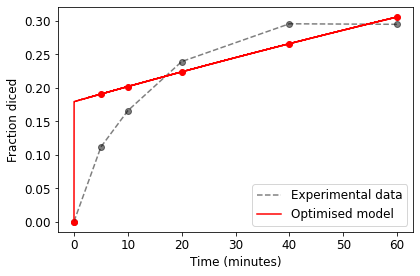

In [137]:


#plot
fig, ax = plt.subplots()

plt.rc('font', size=12)
plt.rcParams['svg.fonttype'] = 'none'

ax.plot(params.time, params.WT_data, color = 'black', alpha = 0.5, ls = '--')
ax.plot(model_time, model, color = 'red')

ax.scatter(params.time, params.WT_data, color = 'black', alpha = 0.5) 
ax.scatter(params.time, model_points, color = 'red')

ax.legend(['Experimental data', 'Optimised model'])
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Fraction diced')

fig.tight_layout()

plt.show()